# INF8245E: Machine Learning | Assignment #2

**Louis Plessis (1933334)** | 24 October 2021

# 1. Linear Classification and Nearest Neighbour Classification

## 1.1. Generating 2 classes with 20 features each

In [1]:
import pandas as pd
import numpy as np

DS1_m_0 = pd.read_csv("DS1_m_0.txt", header=None)
DS1_m_0 = DS1_m_0.drop(columns=[20])
DS1_m_0 = np.array(DS1_m_0).flatten()

DS1_m_1 = pd.read_csv("DS1_m_1.txt", header=None)
DS1_m_1 = DS1_m_1.drop(columns=[20])
DS1_m_1 = np.array(DS1_m_1).flatten()

DS1_Cov = pd.read_csv("DS1_Cov.txt", header=None)
DS1_Cov = DS1_Cov.drop(columns=[20])
DS1_Cov = DS1_Cov.to_numpy()

#Generating 2000 examples
data_positive = np.random.multivariate_normal(DS1_m_1, DS1_Cov, 2000)
data_negative = np.random.multivariate_normal(DS1_m_0, DS1_Cov, 2000)

#Labels
data_positive = np.column_stack((data_positive, np.ones(2000)))
data_negative = np.column_stack((data_negative, -np.ones(2000)))

data = np.concatenate((data_positive, data_negative))

#Shuffling 
np.random.shuffle(data)

#20% test, 20% validation, 60% train
test = pd.DataFrame(data[0:800])
valid = pd.DataFrame(data[800:1600])
train = pd.DataFrame(data[1600:4000])

#Exporting to CSV
test.to_csv("DS1_test.txt",index=False, header=False)
valid.to_csv("DS1_valid.txt",index=False, header=False)
train.to_csv("DS1_train.txt",index=False, header=False)

## 1.2. GDA model

In [2]:
def GDA(train, test):
    tp,fp,fn,tn = 0,0,0,0
    
    ypos = len(np.array(test)[0]) - 1

    train_positive = train[train[ypos]==1]
    train_positive = train_positive.drop(columns=[ypos])

    train_negative = train[train[ypos]==-1]
    train_negative = train_negative.drop(columns=[ypos])

    y_test = test[ypos].to_numpy()

    x_test = test.drop(columns=[ypos])
    x_test = x_test.to_numpy()

    M1 = np.array(train_negative.mean())
    M2 = np.array(train_positive.mean())
    
    covariance_negative = np.array(train_negative - M1)
    covariance_positive = np.array(train_positive - M2)
    
    N1 = len(train_negative)
    N2 = len(train_positive)
    N  = N1+N2

    S1 = np.dot(covariance_negative.T, covariance_negative) / N1
    S2 = np.dot(covariance_positive.T, covariance_positive) / N2

    covariance = (N1/N)*S1 + (N2/N)*S2
    covariance_inverse = np.linalg.inv(covariance)

    P_positive = len(train_positive) / (len(train_negative)+len(train_positive))
    P_negative = len(train_negative) / (len(train_negative)+len(train_positive))

    w = np.dot(covariance_inverse, M1-M2)
    w0 = (-1/2)*np.dot(np.dot(M1.T, covariance_inverse), M1) + (1/2)*np.dot(np.dot(M2.T, covariance_inverse), M2) + np.log(P_negative/P_positive)
    
    #GDA model
    a = np.dot(x_test, w.T) + w0     #a = w^T x + w_0
    P = 1 / ( 1 + np.exp(-a) )       #P = sigma(-a)

    for i in range(len(y_test)):
        if P[i] > 0.5:
            prediction=-1  #Negative
        else:
            prediction=1   #Positive
            
        actual = y_test[i]

        if prediction==1 and prediction==actual:
            tp +=1
        elif prediction==1 and prediction!=actual:
            fp += 1
        elif prediction==-1 and prediction!=actual:
            fn += 1
        elif prediction==-1 and prediction==actual:
            tn += 1

    confusion_matrix = [[tp,fp],[fn,tn]]

    #Accuracy = [number of true / total number]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    print("********************** Accuracy *********************")
    print("\nBest fit accuracy achieved by the classifier: ", accuracy)
    
    print("\n\n**************** Learnt coefficients ****************")
    print("\nMean_negative =", M1)
    print("\nMean_positive =", M2)
    print("\nCovariance =", covariance)
    print("\nP_negative =", P_negative)
    print("\nP_positive =", P_positive)
    print("\nw =", w)
    print("\nw0 =", w0)
    
    print("\nConfusion matrix: ", confusion_matrix)

In [3]:
GDA(train, test)

********************** Accuracy *********************

Best fit accuracy achieved by the classifier:  0.95875


**************** Learnt coefficients ****************

Mean_negative = [1.38796111 1.38480463 1.34313205 1.32022768 1.41542407 1.31962424
 1.38474112 1.31388446 1.44811996 1.38415931 1.43311451 1.37802054
 1.39557523 1.47770518 1.42522795 1.34860382 1.40656817 1.35347971
 1.46513806 1.38616681]

Mean_positive = [1.77001928 1.83872663 1.80206517 1.87441891 1.80576205 1.82425626
 1.84645289 1.87175208 1.89023374 1.84551547 1.88524332 1.88144806
 1.8342172  1.82871093 1.87524358 1.90254666 1.8618322  1.8550372
 1.85403167 1.87095304]

Covariance = [[7.59670177 5.35983662 5.91492305 5.03030236 5.60529499 5.96629202
  4.45563008 5.25173387 4.70544913 4.96802001 3.70113783 5.08412311
  6.78433784 5.75975047 5.82554384 5.76903651 5.6276206  5.55603033
  5.34445838 5.74981195]
 [5.35983662 6.71748357 5.19999723 4.18734891 5.23018483 5.47511227
  4.24091331 3.98571128 3.93344467 4.902

## 1.3. k-NN

### Validation accuracy for different values of k

In [4]:
import matplotlib.pyplot as plt

def k_NN(train, valid, k_max, binary):
    
    ypos = len(np.array(valid)[0]) - 1
    
    y_valid = valid[ypos].to_numpy()
    y_train = train[ypos].to_numpy()

    x_valid = valid.drop(columns=[ypos])
    x_valid = x_valid.to_numpy()

    x_train = train.drop(columns=[ypos])
    x_train = x_train.to_numpy()

    best_accuracy = 0
    accuracies = []

    for k in range(1,k_max):
        true,false = 0,0

        for j in range(len(y_valid)):
            distances = np.linalg.norm(x_valid[j]-x_train, None, 1)
            neighbourhood = np.argsort(distances)
            k_nearest_neighbours = neighbourhood[:k]
            
            prediction = np.mean(y_train[k_nearest_neighbours])
            
            #Should be true if 2 classes positive/negative, false otherwise
            if binary:      
                if prediction > 0:
                    prediction = 1
                else:
                    prediction = -1
            else:
                prediction = round(prediction)
            
            actual = y_valid[j]

            if prediction==actual:
                true +=1
            else:
                false += 1
                
        accuracy = (true)/(true+false)
        accuracies.append(accuracy)

        if(accuracy > best_accuracy):
            best_accuracy = accuracy
            best_k = k
            
    plt.plot(list(range(1,k_max)), accuracies)
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.show()
    
    print('Best fit accuracy:', best_accuracy, 'when k = ', best_k)

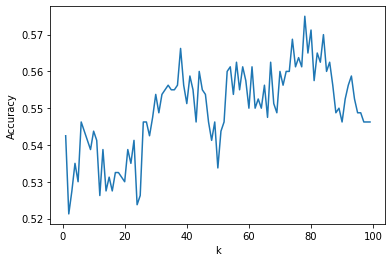

Best fit accuracy: 0.575 when k =  78


In [5]:
k_NN(train, valid, 100, True)

This classifier seems to perform worse than GDA overall ($\sim0.55$ accuracy instead of $\sim0.95$ for GDA). Some specific values of k seem to perform better than others, due to the low stability of this method. However, the difference is very small as the accuracy stays around $55\%$.

## 1.4. Mixture of 3 Gaussians

In [6]:
#Positive: DS2-c1
#Negative: DS2-c2

#mean arrays
DS2_c1_m1 = pd.read_csv("DS2_c1_m1.txt", header=None)
DS2_c1_m1 = DS2_c1_m1.drop(columns=[20])
DS2_c1_m1 = np.array(DS2_c1_m1).flatten()

DS2_c1_m2 = pd.read_csv("DS2_c1_m2.txt", header=None)
DS2_c1_m2 = DS2_c1_m2.drop(columns=[20])
DS2_c1_m2 = np.array(DS2_c1_m2).flatten()

DS2_c1_m3 = pd.read_csv("DS2_c1_m3.txt", header=None)
DS2_c1_m3 = DS2_c1_m3.drop(columns=[20])
DS2_c1_m3 = np.array(DS2_c1_m3).flatten()

DS2_c2_m1 = pd.read_csv("DS2_c2_m1.txt", header=None)
DS2_c2_m1 = DS2_c2_m1.drop(columns=[20])
DS2_c2_m1 = np.array(DS2_c2_m1).flatten()

DS2_c2_m2 = pd.read_csv("DS2_c2_m2.txt", header=None)
DS2_c2_m2 = DS2_c2_m2.drop(columns=[20])
DS2_c2_m2 = np.array(DS2_c2_m2).flatten()

DS2_c2_m3 = pd.read_csv("DS2_c2_m3.txt", header=None)
DS2_c2_m3 = DS2_c2_m3.drop(columns=[20])
DS2_c2_m3 = np.array(DS2_c2_m3).flatten()

#covariance matrices
DS2_Cov1 = pd.read_csv("DS2_Cov1.txt", header=None)
DS2_Cov1 = DS2_Cov1.drop(columns=[20])
DS2_Cov1 = DS2_Cov1.to_numpy()

DS2_Cov2 = pd.read_csv("DS2_Cov2.txt", header=None)
DS2_Cov2 = DS2_Cov2.drop(columns=[20])
DS2_Cov2 = DS2_Cov2.to_numpy()

DS2_Cov3 = pd.read_csv("DS2_Cov3.txt", header=None)
DS2_Cov3 = DS2_Cov3.drop(columns=[20])
DS2_Cov3 = DS2_Cov3.to_numpy()

mix_split_1 = int(2000*0.1)
mix_split_2 = int(2000*0.42)
mix_split_3 = int(2000*0.48)

pos1 = np.random.multivariate_normal(DS2_c1_m1, DS2_Cov1, mix_split_1)
pos2 = np.random.multivariate_normal(DS2_c1_m2, DS2_Cov2, mix_split_2)
pos3 = np.random.multivariate_normal(DS2_c1_m3, DS2_Cov3, mix_split_3)

neg1 = np.random.multivariate_normal(DS2_c2_m1, DS2_Cov1, mix_split_1)
neg2 = np.random.multivariate_normal(DS2_c2_m2, DS2_Cov2, mix_split_2)
neg3 = np.random.multivariate_normal(DS2_c2_m3, DS2_Cov3, mix_split_3)

#Labels
pos1 = np.column_stack((pos1, np.ones(mix_split_1)))
pos2 = np.column_stack((pos2, np.ones(mix_split_2)))
pos3 = np.column_stack((pos3, np.ones(mix_split_3)))

neg1 = np.column_stack((neg1, -np.ones(mix_split_1)))
neg2 = np.column_stack((neg2, -np.ones(mix_split_2)))
neg3 = np.column_stack((neg3, -np.ones(mix_split_3)))

data1 = np.concatenate((pos1, neg1))
data2 = np.concatenate((pos2, neg2))
data3 = np.concatenate((pos3, neg3))

#Shuffling 
np.random.shuffle(data1)
np.random.shuffle(data2)
np.random.shuffle(data3)

#20% test, 20% validation, 60% train
split1 = int(4000*0.1)
split2 = int(split1 + 4000*0.42)
split3 = int(split2 + 4000*0.48)

test1 = pd.DataFrame(data1[0:int(len(data1)*0.2)])
test2 = pd.DataFrame(data2[0:int(len(data2)*0.2)])
test3 = pd.DataFrame(data3[0:int(len(data3)*0.2)])

valid1 = pd.DataFrame(data1[int(len(data1)*0.2):int(len(data1)*0.4)])
valid2 = pd.DataFrame(data2[int(len(data2)*0.2):int(len(data2)*0.4)])
valid3 = pd.DataFrame(data3[int(len(data3)*0.2):int(len(data3)*0.4)])

train1 = pd.DataFrame(data1[int(len(data1)*0.4):int(len(data1))])
train2 = pd.DataFrame(data2[int(len(data2)*0.4):int(len(data2))])
train3 = pd.DataFrame(data3[int(len(data3)*0.4):int(len(data3))])

test = pd.DataFrame(np.concatenate((test1, test2, test3)))
valid = pd.DataFrame(np.concatenate((valid1, valid2, valid3)))
train = pd.DataFrame(np.concatenate((train1, train2, train3)))

In [7]:
#Export to CSV
test.to_csv("DS2_test.txt",index=False, header=False)
valid.to_csv("DS2_valid.txt",index=False, header=False)
train.to_csv("DS2_train.txt",index=False, header=False)

## 1.5. DS2

### 1.5.1. Estimating the parameters of the GDA model using the maximum likelihood approach

In [8]:
GDA(train, test)

********************** Accuracy *********************

Best fit accuracy achieved by the classifier:  0.5075


**************** Learnt coefficients ****************

Mean_negative = [1.27256109 1.24218875 1.2914599  1.33057664 1.29511144 1.18556019
 1.24628351 1.25635201 1.26262108 1.22139844 1.31234446 1.33184905
 1.29710941 1.15561398 1.26534078 1.26492537 1.32194299 1.32341061
 1.24851654 1.29086104]

Mean_positive = [0.92068364 0.96828546 0.98662197 0.93430012 0.96447765 1.00666499
 0.94414745 0.96325523 0.96284449 0.97270541 0.91646454 0.95894061
 1.02767194 0.96403723 0.92911611 0.99505608 1.03159224 1.01400484
 1.0095793  1.00980303]

Covariance = [[7.80951553 5.64762197 4.93717126 5.17490326 4.65761711 6.03649039
  6.09168334 5.76196745 4.86164523 5.48233644 5.57583909 5.15014418
  5.26402254 6.45026518 5.5200406  5.8314485  5.66666603 5.50644124
  5.87202499 6.03128892]
 [5.64762197 7.55619476 5.31457773 5.41371381 5.37492199 6.41831948
  6.77123079 5.62101201 4.86558751 5.362

### 1.5.2., 1.5.3. k-NN

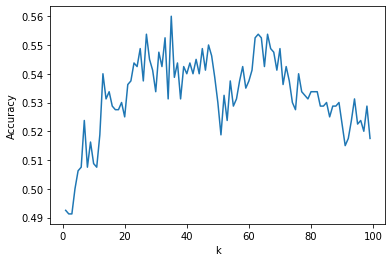

Best fit accuracy: 0.56 when k =  35


In [9]:
k_NN(train, valid, 100, True)

This classifier seems to perform a little bit better than GDA ($\sim0.55$ accuracy for k-NN instead of $\sim0.50$ accuracy for GDA). Some specific values of k seem to perform better than others, due to the low stability of this method. However, the difference is very small as the accuracy stays around $55\%$.

## 1.6. Similarities and differences between the performance of both classifiers

For DS1, GDA seems to perform better than k-NN, but for DS2, it seems to be the opposite. However, k-NN behaves in the same way with both datasets (i.e., some values of k perform better than others, with no visible pattern). Given the very high accuracy for the GDA model using DS1 and the average performance of both models with DS2, we could say that GDA performs better overall.

# 2. MNIST Handwritten Digits Classification

In [10]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#0-50000 = train, 50000-60000 = valid
x_valid = x_train[50000:60000]
y_valid = y_train[50000:60000]

x_train = x_train[0:50000]
y_train = y_train[0:50000]

#Flattening to 784 features
x_train_flattened = []
x_valid_flattened = []
x_test_flattened = []

for i in range(len(x_train)):
    x_train_flattened.append(x_train[i].flatten())
    
for i in range(len(x_valid)):
    x_valid_flattened.append(x_valid[i].flatten())
    
for i in range(len(x_test)):
    x_test_flattened.append(x_test[i].flatten())

#Normalizing
x_train = np.array(x_train_flattened)/255
x_valid = np.array(x_valid_flattened)/255
x_test = np.array(x_test_flattened)/255

train = pd.DataFrame(np.column_stack((x_train, y_train)))
valid = pd.DataFrame(np.column_stack((x_valid, y_valid)))
test = pd.DataFrame(np.column_stack((x_test, y_test)))

## 2.1. Gaussian Naive Bayes (GNB)

### 2.1. (a) Equations for mean and diagonal covariance matrices

Prior class probability for each class $i$:

$$P = \frac{\text{number of examples of class }i}{\text{total number of examples}}$$


Mean for each class $i$: 
$$\mu_i = \frac{1}{N_i} \sum^{N}_{n=1} t^{(n)}_{i} x^{(n)}$$

Covariance matrix for each class $i$:
$$\Sigma_i = \frac{1}{N_i} \sum^{N}_{n=1} t^{(n)}_{i} (x^{(n)}-\mu_i)(x^{(n)}-\mu_i)^T$$

Since the covariance matrix must be diagonal, each value that is not on the diagonal is 0.

### 2.1. (b) Estimating GNB model parameters

In [11]:
ypos = len(np.array(test)[0]) - 1
y_test = test[ypos].to_numpy()

covariance_matrix = []
M = []
P = []
noise = 0.0000000000000000001

for i in range(10):
    print("**************** Class", i, "****************")
    x_train_i = train[train[ypos]==i]
    x_train_i = x_train_i.drop(columns=[ypos])
    x_train = train.drop(columns=[ypos])

    #Probability
    P.append(len(x_train_i)/len(x_train))
    print("P =", P[i])
    
    #Means
    M.append(np.mean(x_train))
    print("Mean =", M[i])
    
    #Covariance matrix
    covariance = np.diag(np.diag(np.cov(x_train_i, None, False)))
    print("Covariance =", covariance)
    covariance[covariance==0] = 99
    for a in range(784):
        for b in range(784):
            if covariance[a][b] == float(99):
                covariance[a][b] = noise
                noise += 0.0000000000000000001
     #Laplace smoothing
    print("Covariance_after_smoothing =", covariance)
    covariance_matrix.append(covariance)

**************** Class 0 ****************
P = 0.09864
Mean = 0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
779    0.000009
780    0.000000
781    0.000000
782    0.000000
783    0.000000
Length: 784, dtype: float64
Covariance = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Covariance_after_smoothing = [[1.00000e-19 2.00000e-19 3.00000e-19 ... 7.82000e-17 7.83000e-17
  7.84000e-17]
 [7.85000e-17 7.86000e-17 7.87000e-17 ... 1.56600e-16 1.56700e-16
  1.56800e-16]
 [1.56900e-16 1.57000e-16 1.57100e-16 ... 2.35000e-16 2.35100e-16
  2.35200e-16]
 ...
 [6.11742e-14 6.11743e-14 6.11744e-14 ... 6.12523e-14 6.12524e-14
  6.12525e-14]
 [6.12526e-14 6.12527e-14 6.12528e-14 ... 6.13307e-14 6.13308e-14
  6.13309e-14]
 [6.13310e-14 6.13311e-14 6.13312e-14 ... 6.14091e-14 6.14092e-14
  6.14093e-14]]
**************** Class 1 ****************
P =

Covariance_after_smoothing = [[4.912624e-13 4.912625e-13 4.912626e-13 ... 4.913405e-13 4.913406e-13
  4.913407e-13]
 [4.913408e-13 4.913409e-13 4.913410e-13 ... 4.914189e-13 4.914190e-13
  4.914191e-13]
 [4.914192e-13 4.914193e-13 4.914194e-13 ... 4.914973e-13 4.914974e-13
  4.914975e-13]
 ...
 [5.524375e-13 5.524376e-13 5.524377e-13 ... 5.525156e-13 5.525157e-13
  5.525158e-13]
 [5.525159e-13 5.525160e-13 5.525161e-13 ... 5.525940e-13 5.525941e-13
  5.525942e-13]
 [5.525943e-13 5.525944e-13 5.525945e-13 ... 5.526724e-13 5.526725e-13
  5.526726e-13]]
**************** Class 9 ****************
P = 0.09976
Mean = 0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
779    0.000009
780    0.000000
781    0.000000
782    0.000000
783    0.000000
Length: 784, dtype: float64
Covariance = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Covarianc

In [12]:
"""
true,false = 0,0
z=0

for i in y_test:
    preds = []
    for j in range(10):      
        prob = np.log(P[j])
        covariance_inverse = np.linalg.inv(covariance_matrix[j])
        covariance_inverse_det = np.linalg.det(covariance_inverse)
        #l = (-1/2)*((i-M[j]).T) + (1/2)*(np.log(covariance_inverse_det))
        #preds.append(prob + l)
        preds.append(prob)
        
    prediction = np.argmax(preds)
    actual = i
    
    if prediction==actual:
        true += 1
    else:
        false += 1

accuracy = (true)/(true+false)

print('Best fit accuracy:', accuracy)

"""

'\ntrue,false = 0,0\nz=0\n\nfor i in y_test:\n    preds = []\n    for j in range(10):      \n        prob = np.log(P[j])\n        covariance_inverse = np.linalg.inv(covariance_matrix[j])\n        covariance_inverse_det = np.linalg.det(covariance_inverse)\n        #l = (-1/2)*((i-M[j]).T) + (1/2)*(np.log(covariance_inverse_det))\n        #preds.append(prob + l)\n        preds.append(prob)\n        \n    prediction = np.argmax(preds)\n    actual = i\n    \n    if prediction==actual:\n        true += 1\n    else:\n        false += 1\n\naccuracy = (true)/(true+false)\n\nplt.plot(list(range(1,k_max)), accuracies)\nplt.xlabel("k")\nplt.ylabel("Accuracy")\nplt.show()\n\nprint(\'Best fit accuracy:\', best_accuracy)\n\n'

## 2.2. k-NN

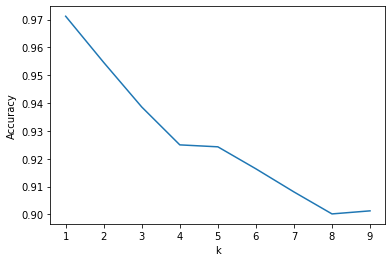

Best fit accuracy: 0.9712 when k =  1


In [13]:
k_NN(train, valid, 10, False)

See report.

## 2.3. GNB performance vs k-NN

See report.